## Example. Estimating the speed of light

Simon Newcomb's measurements of the speed of light, from

> Stigler, S. M. (1977). Do robust estimators work with real data? (with discussion). *Annals of
Statistics* **5**, 1055–1098. 

The data are recorded as deviations from $24\ 800$
nanoseconds.  Table 3.1 of Bayesian Data Analysis.

28 26 33 24 34 -44 27 16 40 -2
29 22 24 21 25 30 23 29 31 19
24 20 36 32 36 28 25 21 28 29
37 25 28 26 30 32 36 26 30 22
36 23 27 27 28 27 31 27 26 33
26 32 32 24 39 28 24 25 32 25
29 27 28 29 16 23

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

from scipy.optimize import brentq

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [2]:
numbs = "28 26 33 24 34 -44 27 16 40 -2 29 22 \
24 21 25 30 23 29 31 19 24 20 36 32 36 28 25 21 28 29 \
37 25 28 26 30 32 36 26 30 22 36 23 27 27 28 27 31 27 26 \
33 26 32 32 24 39 28 24 25 32 25 29 27 28 29 16 23"

In [3]:
nums = np.array([int(i) for i in numbs.split(' ')])

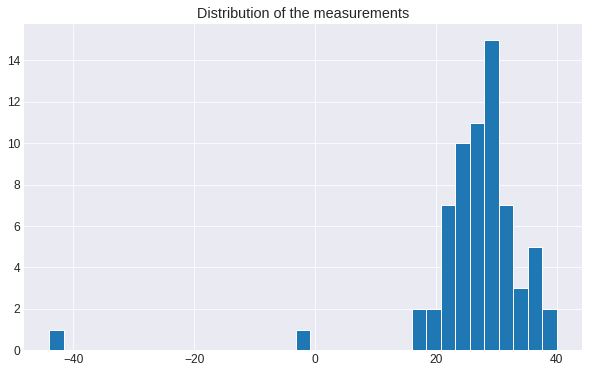

In [4]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(nums, bins=35, edgecolor='w')
plt.title('Distribution of the measurements');

In [5]:
mean_t = np.mean(nums)
print(f'The mean of the 66 measurements is {mean_t:.1f}')

The mean of the 66 measurements is 26.2


In [6]:
std_t = np.std(nums, ddof=1)
print(f'The standard deviation of the 66 measurements is {std_t:.1f}')

The standard deviation of the 66 measurements is 10.7


And now, we use `pymc3` to estimate the mean and the standard deviation from the data.

In [7]:
with pm.Model() as model_1:
    mu = pm.Uniform('mu', lower=10, upper=30)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    post = pm.Normal('post', mu=mu, sd=sigma, observed=nums)

In [8]:
with model_1:
    trace_1 = pm.sample(draws=50_000, tune=50_000)

<ipython-input-8-515ecd7a4f2d>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(draws=50_000, tune=50_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 50_000 tune and 50_000 draw iterations (200_000 + 200_000 draws total) took 80 seconds.


/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


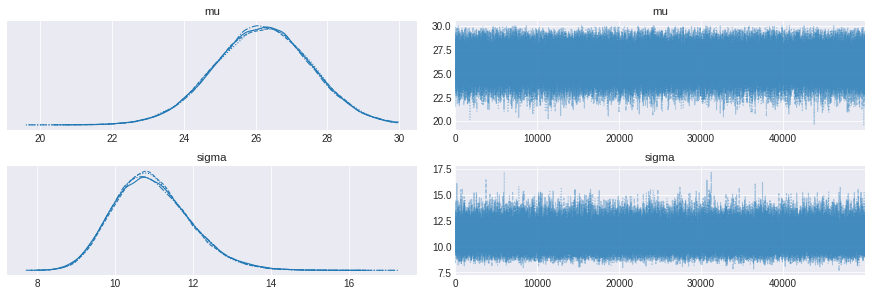

In [9]:
az.plot_trace(trace_1);

In [10]:
df = pm.summary(trace_1)
df.style.format('{:.4f}')

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,26.1920,1.3480,23.6920,28.7650,0.0040,0.0030,96121.0000,61279.0000,1.0000
sigma,10.9500,0.9830,9.1510,12.7820,0.0030,0.0020,133034.0000,112433.0000,1.0000


As you can see, the highest posterior interval for `mu` is [23.69, 28.77].

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


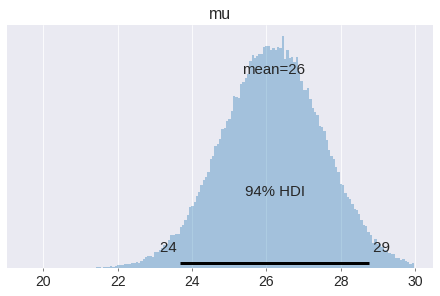

In [11]:
pm.plot_posterior(trace_1, var_names=['mu'], kind = 'hist');

The true posterior distribution is $t_{65}$

In [12]:
from scipy.stats import t

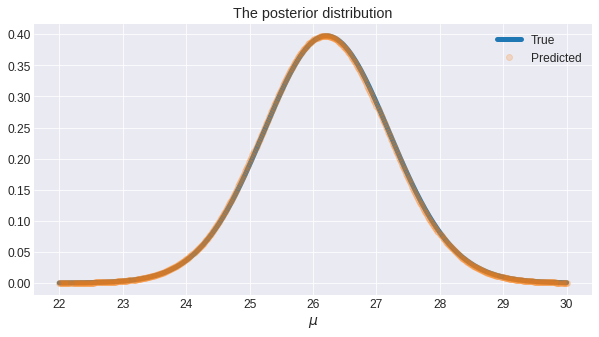

In [13]:
x = np.linspace(22, 30, 500)
y = t.pdf(x, 65, loc=mean_t)

y_pred = t.pdf(x, 65, loc=df['mean'].values[0])

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='True', linewidth=5)
plt.plot(x, y_pred, 'o', label='Predicted', alpha=0.2)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\mu$', fontsize=14);

The book says you can find the posterior interval by simulation, so let's do that with Python. First, draw random values of $\sigma^2$ and $\mu$.

In [14]:
mu_estim = []

for i in range(10_000):
    y = np.random.chisquare(65)
    y2 = 65 * std_t**2 / y
    yy = np.random.normal(loc=mean_t, scale=y2/66)
    mu_estim.append(yy)

To visualize `mu_estim`, we plot a histogram.

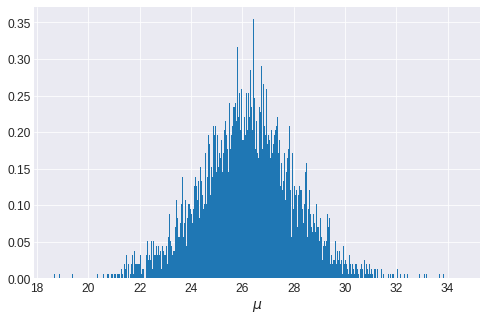

In [15]:
plt.figure(figsize=(8,5))
rang, bins1, _ = plt.hist(mu_estim, bins=1000, density=True)
plt.xlabel(r'$\mu$', fontsize=14);

The advantage here is that you can find the median and the central posterior interval. Well, the median is...

In [16]:
idx = bins1.shape[0] // 2
print((bins1[idx] + bins1[idx + 1]) / 2) 

26.589526003166377


And the central posterior interval is... not that easy to find. We have to find $a$ such as:

$$\int_{\mu -a}^{\mu +a} f(x)\, dx = 0.95,$$

with $\mu$ the median. We need to define $dx$ and $f(x)$. 


In [17]:
delta_bin = bins1[1] - bins1[0]
print(f'This is delta x: {delta_bin}')

This is delta x: 0.015811883813082517


We define a function to find $a$ (in fact, $a$ is an index). `rang` is $f(x)$.

In [18]:
def func3(a):
    return sum(rang[idx - int(a):idx + int(a)] * delta_bin) - 0.95

In [19]:
idx_sol = brentq(func3, 0, idx)
idx_sol

239.00000000000082

That number is an index, therefore the interval is:

In [20]:
l_i = bins1[idx - int(idx_sol)]
l_d = bins1[idx + int(idx_sol)]

print(f'The central posterior interval is [{l_i:.2f}, {l_d:.2f}]')

The central posterior interval is [22.80, 30.36]


## Example. Pre-election polling

Let's put that in code.

In [21]:
obs = np.array([727, 583, 137])
bush_supp = obs[0] / sum(obs)
dukakis_supp = obs[1] / sum(obs)
other_supp = obs[2] / sum(obs)

arr = np.array([bush_supp, dukakis_supp, other_supp])
print('The proportion array is', arr)
print('The supporters array is', obs)

The proportion array is [0.5024188  0.40290256 0.09467865]
The supporters array is [727 583 137]


Remember that we want to find the distribution of $\theta_1 - \theta_2$. In this case, the prior distribution on each $\theta$ is a uniform distribution; the data $(y_1, y_2, y_3)$ follow a multinomial distribution, with parameters $(\theta_1, \theta_2, \theta_3)$.

In [22]:
import theano
import theano.tensor as tt

In [23]:
with pm.Model() as model_3:

    theta1 = pm.Uniform('theta1', lower=0, upper=1)
    theta2 = pm.Uniform('theta2', lower=0, upper=1)
    theta3 = pm.Uniform('theta3', lower=0, upper=1)
    post = pm.Multinomial('post', n=obs.sum(), p=[theta1, theta2, theta3], observed=obs)
    
    diff = pm.Deterministic('diff', theta1 - theta2)

In [24]:
model_3.check_test_point()

theta1_interval__     -1.39
theta2_interval__     -1.39
theta3_interval__     -1.39
post                -243.49
Name: Log-probability of test_point, dtype: float64

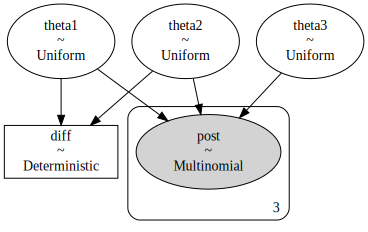

In [25]:
pm.model_to_graphviz(model_3)

In [26]:
with model_3:
    trace_3 = pm.sample(draws=50_000, tune=50_000)

<ipython-input-26-3191f5cfe642>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3 = pm.sample(draws=50_000, tune=50_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta3, theta2, theta1]


Sampling 4 chains for 50_000 tune and 50_000 draw iterations (200_000 + 200_000 draws total) took 95 seconds.
There were 11265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4503228911215456, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2788 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6828149239319151, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4469 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6259957965532099, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7889 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5340178351169285, but shoul

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


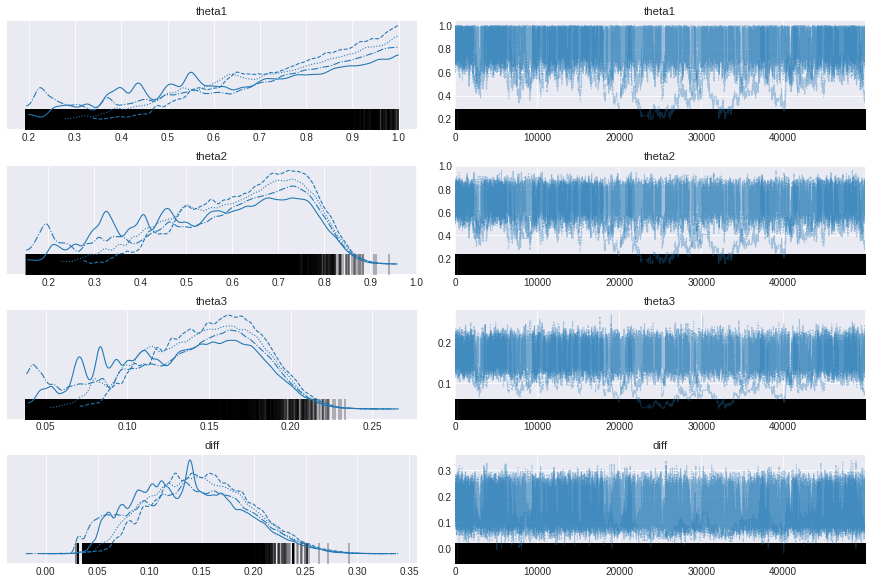

In [27]:
az.plot_trace(trace_3);

In [28]:
pm.summary(trace_3, kind = "stats")

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
theta1,0.741,0.193,0.391,1.000
theta2,0.597,0.160,0.298,0.856
theta3,0.141,0.039,0.067,0.210
diff,0.144,0.050,0.052,0.234


In [29]:
pm.summary(trace_3, kind = "diagnostics")

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,0.023,0.016,93.0,65.0,1.04
theta2,0.019,0.013,93.0,68.0,1.04
theta3,0.004,0.003,92.0,68.0,1.04
diff,0.004,0.003,136.0,104.0,1.02


As you can see, the way we write the model is not good, that's why you see a lot of divergences and `ess_bulk` (the bulk effective sample size) as well as `ess_tail` (the tail effective sample size) are very, very low. This can be improved.

In [30]:
with pm.Model() as model_4:
    theta = pm.Dirichlet('theta', a=np.ones_like(obs))
    post = pm.Multinomial('post', n=obs.sum(), p=theta, observed=obs)

In [31]:
with model_4:
    trace_4 = pm.sample(10_000, tune=5000)

<ipython-input-31-778e72816e40>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4 = pm.sample(10_000, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 9 seconds.


/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


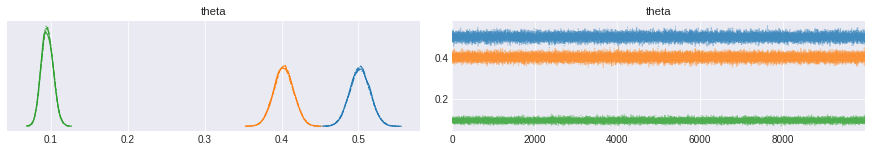

In [32]:
az.plot_trace(trace_4);

In [33]:
pm.summary(trace_4)

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.502,0.013,0.477,0.527,0.0,0.0,32942.0,29265.0,1.0
theta[1],0.403,0.013,0.379,0.427,0.0,0.0,33501.0,28670.0,1.0
theta[2],0.095,0.008,0.081,0.110,0.0,0.0,34504.0,27597.0,1.0


Better trace plot and better `ess_bulk`/`ess_tail`. Now we can estimate $\theta_1 - \theta_2$, we draw 4000 points from the posterior distribution.

In [34]:
post_samples = pm.sample_posterior_predictive(trace_4, samples=4_000, model=model_4)

/home/xyj/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [35]:
diff = []
sum_post_sample = post_samples['post'].sum(axis=1)[0]

for i in range(post_samples['post'].shape[0]):
    diff.append((post_samples['post'][i, 0] - 
                post_samples['post'][i, 1]) /  sum_post_sample)

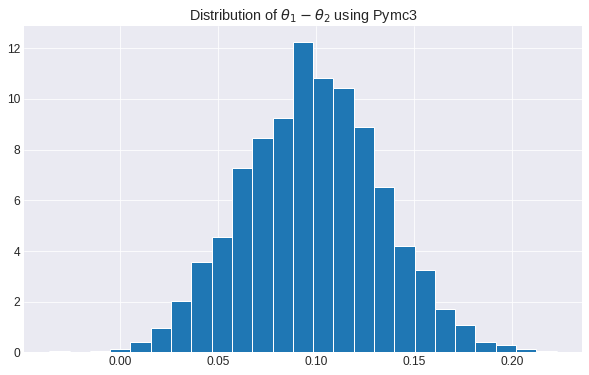

In [36]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(diff, bins=25, edgecolor='w', density=True)
plt.title(r'Distribution of $\theta_1 - \theta_2$ using Pymc3');

Of course you can compare this result with the true posterior distribution

In [37]:
from scipy.stats import dirichlet

In [38]:
ddd = dirichlet([728, 584, 138])

rad = []
for i in range(4_000):
    rad.append(ddd.rvs()[0][0] - ddd.rvs()[0][1])

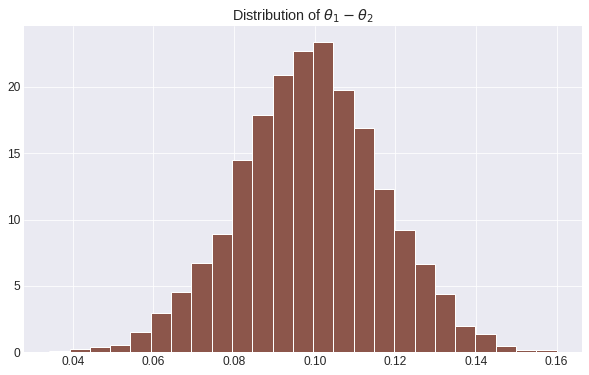

In [39]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(rad, color='C5', bins=25, edgecolor='w', density=True)
plt.title(r'Distribution of $\theta_1 - \theta_2$');

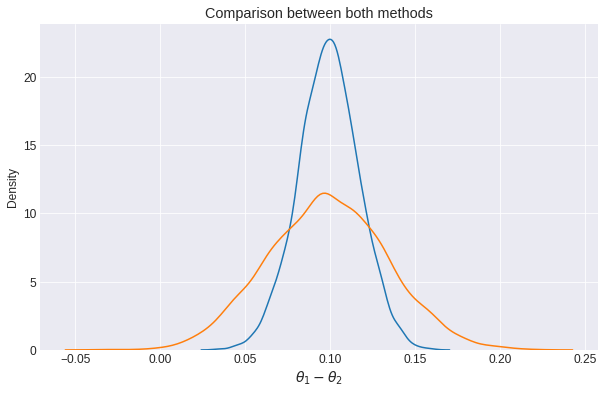

In [40]:
plt.figure(figsize=(10, 6))
sns.kdeplot(rad, label='True')
sns.kdeplot(diff, label='Predicted');
plt.title('Comparison between both methods')
plt.xlabel(r'$\theta_1 - \theta_2$', fontsize=14);

## Example: analysis of a bioassay experiment

This information is in Table 3.1

In [41]:
x_dose = np.array([-0.86, -0.3, -0.05, 0.73])
n_anim = np.array([5, 5, 5, 5])
y_deat = np.array([0, 1, 3, 5])

In [42]:
with pm.Model() as model_5:
    alpha = pm.Uniform('alpha', lower=-5, upper=7)
    beta = pm.Uniform('beta', lower=0, upper=50)
    
    theta = pm.math.invlogit(alpha + beta * x_dose)
    
    post = pm.Binomial('post', n=n_anim, p=theta, observed=y_deat)

In [43]:
with model_5:
    trace_5 = pm.sample(draws=10_000, tune=15_000)

<ipython-input-43-16c781b331bd>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_5 = pm.sample(draws=10_000, tune=15_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.7184806317419475, but should be close to 0.8. Try to increase the number of tuning steps.


/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


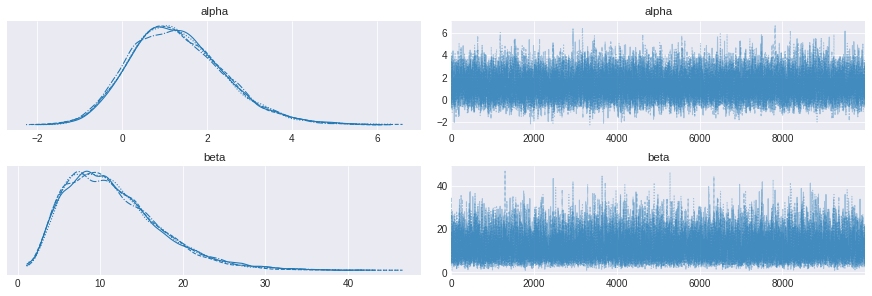

In [44]:
az.plot_trace(trace_5);

In [45]:
df5 = pm.summary(trace_5)
df5.style.format('{:.4f}')

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.3110,1.1220,-0.7050,3.4350,0.0100,0.0080,12706.0000,12120.0000,1.0000
beta,11.5930,5.8250,2.2730,22.0700,0.0530,0.0380,12415.0000,15729.0000,1.0000


The next plots are a scatter plot, a plot for the posterior for `alpha` and `beta` and a countour plot.

/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/xyj/anaconda3/lib/python3.8/site-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


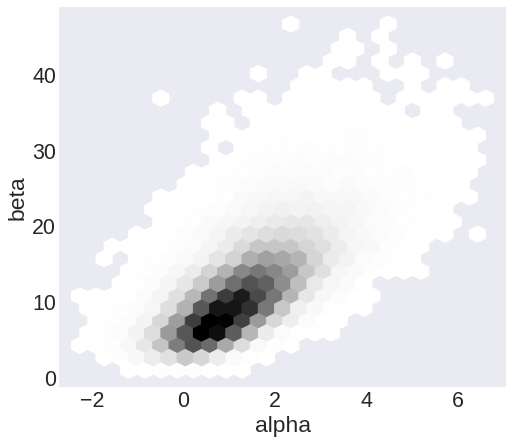

In [46]:
az.plot_pair(trace_5, figsize=(8, 7), divergences=True, kind = "hexbin");

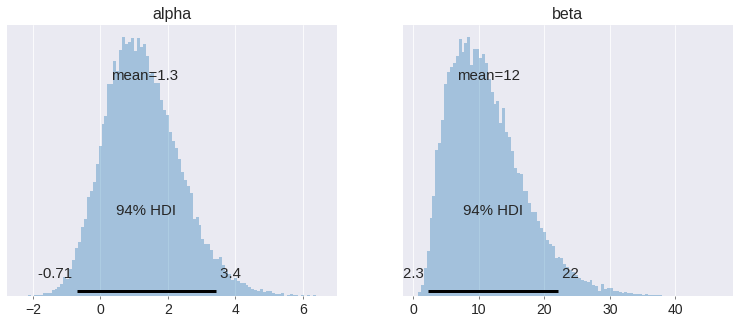

In [47]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(13, 5))
az.plot_posterior(trace_5, ax=ax, kind='hist');

/home/xyj/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


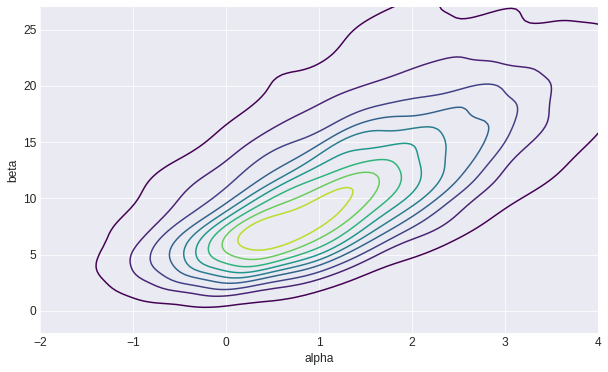

In [48]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(trace_5['alpha'][30000:40000], trace_5['beta'][30000:40000], 
            cmap=plt.cm.viridis, ax=ax, n_levels=10)
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 27)
ax.set_xlabel('alpha')
ax.set_ylabel('beta');

Histogram of the draws from the posterior distribution of the LD50

In [49]:
ld50 = []

begi = 1500
for i in range(1000):
    ld50.append( - trace_5['alpha'][begi + i] / trace_5['beta'][begi + i])

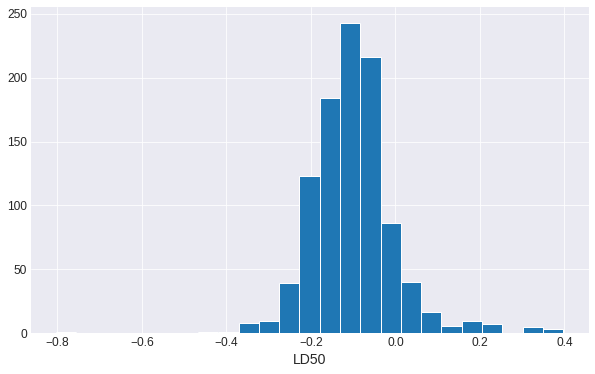

In [50]:
plt.figure(figsize=(10, 6))
_, _, _, = plt.hist(ld50, bins=25, edgecolor='w')
plt.xlabel('LD50', fontsize=14);

In [51]:
%load_ext watermark

In [52]:
%watermark -iv -v -p theano,scipy,matplotlib -m

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

theano    : 1.1.2
scipy     : 1.6.2
matplotlib: 3.3.4

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.11.0-34-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

arviz     : 0.11.2
pymc3     : 3.11.4
matplotlib: 3.3.4
theano    : 1.1.2
sys       : 3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
numpy     : 1.20.1
seaborn   : 0.11.1

